##### ASakai
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter_localization.ipynb

##### RLabbe
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [1]:
import os
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
file_path = os.path.join(os.getcwd(), 'data')
drive_file = 'output.json'
# message_file = 'drive_messages_200703.json'

def load_json_fstr(fstr):
    with open(os.path.join(file_path, fstr), 'r') as f:
        res = json.load(f)
    return res

drive_data = load_json_fstr(drive_file)
# message_data = load_json_fstr(message_file)

In [3]:
pprint(drive_data)
# pprint(message_data)

[{'gps_x': -3.773242246594317,
  'gps_y': 0.31595645672834327,
  'odometer_x': -3.7217173743012357,
  'odometer_y': 0.21676283525363438},
 {'gps_x': -3.7489594534969317,
  'gps_y': 0.2140514148221447,
  'odometer_x': -3.7216616033622127,
  'odometer_y': 0.2695264174269965},
 {'gps_x': -3.656246005690853,
  'gps_y': 0.4234804431809103,
  'odometer_x': -3.7216044337376406,
  'odometer_y': 0.3236932531150346},
 {'gps_x': -3.7194140331957977,
  'gps_y': 0.548436737844205,
  'odometer_x': -3.7215484816712174,
  'odometer_y': 0.37662996771280133},
 {'gps_x': -3.7208871412384843,
  'gps_y': 0.7599277935587568,
  'odometer_x': -3.7214913772619918,
  'odometer_y': 0.43074675111723837},
 {'gps_x': -3.7315001721109318,
  'gps_y': 0.8164620296889589,
  'odometer_x': -3.721433345470766,
  'odometer_y': 0.48528547507581943},
 {'gps_x': -3.807698665117086,
  'gps_y': 1.1400685099380616,
  'odometer_x': -3.7213753162972028,
  'odometer_y': 0.540355642428792},
 {'gps_x': -3.7706111159153495,
  'gps_y':

Set Initial Conditions

In [16]:
prior_dat = {
#     't': drive_data[0].get('t'),
    'gps_x': 0,
    'gps_y': 0, 
    'odometer_x': 0,
    'odometer_y': 0
#     'theta_control': drive_data[0].get('theta_control'),
#     'theta_sensor': drive_data[0].get('theta_control')
}

x_true = np.array([0, 0])

F = np.identity(2)
P = np.identity(2)
H = np.identity(2)
Q = np.zeros([2,2])
R = np.zeros([2,2])

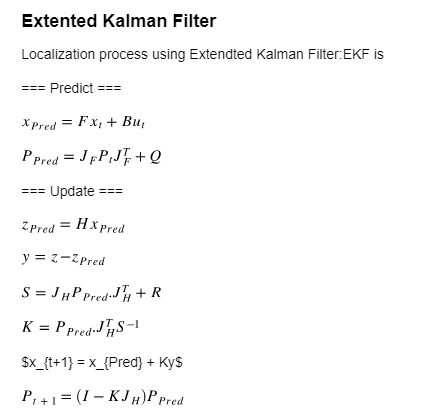

In [17]:
for i, curr_dat in enumerate(drive_data, 1):
#     dt = curr_dat['t'] - prior_dat['t']
    u_t_sensor = np.array(
        [curr_dat['gps_x'] - prior_dat['gps_x'],
         curr_dat['gps_y'] - prior_dat['gps_y']])
#          curr_dat['theta_control'] - prior_dat['theta_control']])
    
    u_t_control = np.array(
        [curr_dat['odometer_x'] - prior_dat['odometer_x'],
         curr_dat['odometer_y'] - prior_dat['odometer_y']])
#          curr_dat['theta_sensor'] - prior_dat['theta_sensor']])
    
    r_control = 10e-2
    J_control = np.array([
        [1, 0],
        [0, 1]])
    
    r_sensor = 10e-2
    J_sensor = np.array([
        [1, 0],
        [0, 1]])
    
        # What to plugin to alpha 1-4?
    alpha_1, alpha_2, alpha_3, alpha_4 = 10e-7, 15e-7, 5e-7, 20e-7
    alpha_1, alpha_2, alpha_3, alpha_4 = (10,) * 4
    qalpha_1, qalpha_2, qalpha_3, qalpha_4 = (1,) * 4
    
    R_t_1_1 = alpha_1 + alpha_2 
    R_t_2_2 = alpha_3 + alpha_4
    R = np.array([
        [R_t_1_1, 0],
        [0, R_t_2_2]
    ])
    
    Q_t_1_1 = qalpha_1 + qalpha_2 
    Q_t_2_2 = qalpha_3 + qalpha_4 
    Q = np.array([
        [Q_t_1_1, 0],
        [0, Q_t_2_2]
    ])
    
    # === Predict ===
    x_pred_control = x_true + u_t_control
    x_pred_sensor = x_true + u_t_sensor
    P_pred = J_control.dot(P).dot(J_control.T) + Q
    # === Update ===
    z_pred_control = H.dot(x_pred_control)
    z_pred_sensor = H.dot(x_pred_sensor)
    y = z_pred_sensor - z_pred_control
    S = J_sensor.dot(P_pred).dot(J_sensor.T) + R
    K = P_pred.dot(J_sensor.T).dot(np.linalg.inv(S))
    x_true = x_pred_control + K.dot(y)
    
    # Review
    print(
        f"x_true: {x_true}"
        # f"\nP {P}"
        f"\ny: {y}"
        f"\n"
    )
    # Setup for Next Iteration
    curr_dat['x_true'] = x_true[0]
    curr_dat['y_true'] = x_true[1]
    prior_dat = curr_dat
        

x_true: [-3.72843801  0.22970113]
y: [-0.05152487  0.09919362]

x_true: [-3.72522219  0.26229055]
y: [ 0.02422702 -0.15466862]

x_true: [-3.71307942  0.33670897]
y: [0.09265628 0.15526219]

x_true: [-3.72127008  0.39903955]
y: [-0.06322398  0.07201958]

x_true: [-3.72141256  0.47368341]
y: [-0.00153021  0.15737427]

x_true: [-3.72274641  0.52848242]
y: [-0.01067106  0.00199551]

x_true: [-3.73263488  0.61857906]
y: [-0.07625652  0.26853631]

x_true: [-3.72774857  0.68620127]
y: [0.03703142 0.11667227]

x_true: [-3.72686969  0.73779483]
y: [ 0.00630526 -0.00818937]

x_true: [-3.71620387  0.80209656]
y: [0.08134    0.08757721]

x_true: [-3.71015844  0.86415222]
y: [0.04590388 0.05985764]

x_true: [-3.71165471  0.92852078]
y: [-0.0119037   0.08867818]

x_true: [-3.72794255  1.00088161]
y: [-0.12529631  0.15083704]

x_true: [-3.71181025  1.08503774]
y: [0.12324974 0.24432293]

x_true: [-3.72103061  1.14813332]
y: [-0.07112173  0.08379289]

x_true: [-3.70748972  1.21157728]
y: [0.10338991 0

In [18]:
print(drive_data[-1])

{'gps_x': -3.7088694903856947, 'gps_y': 2.9939877719944197, 'odometer_x': -3.7206923946613224, 'odometer_y': 1.1770226885440631, 'x_true': -3.7191502767123263, 'y_true': 1.4140181342115006}


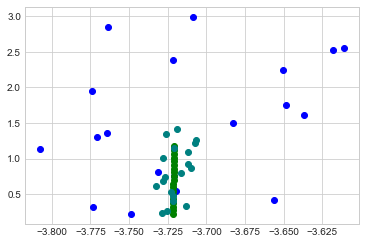

In [19]:
gps_x = [dat.get('gps_x') for dat in drive_data]
gps_y = [dat.get('gps_y') for dat in drive_data]
odometer_x = [dat.get('odometer_x') for dat in drive_data]
odometer_y = [dat.get('odometer_y') for dat in drive_data]
x_true = [dat.get('x_true') for dat in drive_data]
y_true = [dat.get('y_true') for dat in drive_data]

fig = plt.figure()
plt.plot(gps_x, gps_y, 'o', color='blue')
plt.plot(odometer_x, odometer_y, 'o', color='green')
plt.plot(x_true, y_true, 'o', color='teal')
plt.show()
# fig.savefig('plot.png')

In [11]:
print(K.dot(y))

[-0.00715885 -0.01142735]


In [12]:
print(K)

[[0.13043478 0.        ]
 [0.         0.13043478]]


In [10]:
R = np.zeros([3,3])
print(R)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
